# Отток клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 


Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### Описание данных

#### Признаки  
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

#### Целевой признак  
- *Exited* — факт ухода клиента

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные содержат пропуски (около 10%) в столбце *Tenure*, обработаем их заполнением медианой. Категориальные данные нужно преобразовать в количественные методом *One-hot-encoding*, а лучше их комбинацией: для столбца *Surname* применить метод *Ordinal Encoding*, так как столбец содержит большое количество уникальных значений. Так данные не разобьются на тысяци столбцов и модели будут бытрее обучаться. Также требуется масштабирование данных.

In [3]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
#Ordinal Encoding для столбца Surname
encoder = OrdinalEncoder()
data_encode = data.loc[:, ['Surname']]
data_ordinal = pd.DataFrame(encoder.fit_transform(data_encode),
                            columns=data_encode.columns)
data_ordinal

,Surname
0,1115.0
1,1177.0
2,2040.0
3,289.0
4,1822.0
...,...
9995,1999.0
9996,1336.0
9997,1570.0
9998,2345.0


In [5]:
#One-hot-encoding
data = data.drop(['RowNumber', 'Surname'], axis=1)
data = pd.get_dummies(data, drop_first=True)

In [6]:
data_encoding = data.join(data_ordinal)
data_encoding

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Surname
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0,1115.0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0,1177.0
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0,2040.0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0,289.0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0,1822.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1,1999.0
9996,15569892,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1,1336.0
9997,15584532,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0,1570.0
9998,15682355,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1,2345.0


In [7]:
data_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
CustomerId           10000 non-null int64
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
Surname              10000 non-null float64
dtypes: float64(4), int64(7), uint8(3)
memory usage: 888.8 KB


In [8]:
target = data_encoding['Exited']
features = data_encoding.drop('Exited', axis=1)

In [9]:
#Разобъем данные на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [11]:
numeric = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary', 'Surname']

In [12]:
#Масштабирование данных
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Данные разбиты на выборки и подготовлены к обучению модели.

# 2. Исследование задачи

In [13]:
target_train.value_counts()

0    4804
1    1196
Name: Exited, dtype: int64

In [14]:
features_train

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Surname
7479,-0.268372,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1,0.318317
3411,1.725540,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0,0.429288
6027,1.501580,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1,-0.692229
1247,0.277174,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1,-0.432509
3716,0.113431,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0,0.105819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,-0.956103,-1.073677,-0.752805,-0.373701,-1.233163,0.830152,0,1,-1.278361,0,0,1,0.214429
4094,0.965571,-1.447531,-0.942612,1.810266,-1.233163,0.830152,0,1,-1.281307,0,0,1,-0.851602
3492,-0.899911,0.027113,0.575842,-0.009707,-0.310229,-0.891560,0,1,-0.903158,0,0,0,-0.309733
2177,-0.745094,0.151731,-1.417129,-0.373701,-1.233163,0.830152,0,1,-1.128539,0,0,0,-0.469106


Классы не сбалансированы, класс 0 более чем в 4 раза превоходит класс 1.

In [15]:
#логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.33670033670033667

In [16]:
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.758104029179949

In [17]:
#решающее дерево
for depth in range(2, 23, 2):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'depth = ', depth)

f1 = 0.5217391304347825 depth =  2
f1 = 0.5515151515151515 depth =  4
f1 = 0.5731523378582202 depth =  6
f1 = 0.5531914893617021 depth =  8
f1 = 0.5531914893617021 depth =  10
f1 = 0.5340179717586649 depth =  12
f1 = 0.5104808877928483 depth =  14
f1 = 0.5108958837772397 depth =  16
f1 = 0.5017751479289941 depth =  18
f1 = 0.5005988023952096 depth =  20
f1 = 0.508313539192399 depth =  22


Наибольшее f1=0.573 при максимальной глубине 6.

In [18]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train, target_train)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8208985355585262

In [19]:
#случайный лес
for estim in range(4, 121, 4):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'estim =', estim)

f1 = 0.46794871794871795 estim = 4
f1 = 0.4945226917057902 estim = 8
f1 = 0.5294117647058824 estim = 12
f1 = 0.546583850931677 estim = 16
f1 = 0.5417322834645669 estim = 20
f1 = 0.5482866043613708 estim = 24
f1 = 0.5499231950844854 estim = 28
f1 = 0.5488372093023256 estim = 32
f1 = 0.5507692307692309 estim = 36
f1 = 0.5644171779141105 estim = 40
f1 = 0.5661538461538462 estim = 44
f1 = 0.5705521472392637 estim = 48
f1 = 0.5718654434250765 estim = 52
f1 = 0.5569230769230769 estim = 56
f1 = 0.5622119815668203 estim = 60
f1 = 0.5657492354740061 estim = 64
f1 = 0.565284178187404 estim = 68
f1 = 0.5608628659476117 estim = 72
f1 = 0.5643410852713179 estim = 76
f1 = 0.5709876543209876 estim = 80
f1 = 0.5683229813664596 estim = 84
f1 = 0.5714285714285714 estim = 88
f1 = 0.577639751552795 estim = 92
f1 = 0.5754276827371695 estim = 96
f1 = 0.5700934579439253 estim = 100
f1 = 0.5709828393135726 estim = 104
f1 = 0.5736434108527132 estim = 108
f1 = 0.5638629283489096 estim = 112
f1 = 0.5656249999999

Наилучший показатель f1-меры при количестве деревьев равном 92: f1 = 0.578.

In [20]:
model = RandomForestClassifier(random_state=12345, n_estimators=92)
model.fit(features_train, target_train)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8360503027480206

### Вывод

В данных наблюдается дисбаланс классов: класс 0 в 4 раза больше класса 1. Как и следовало ожидать модель случайного леса показала наилучшие результаты: метрика f1 = 0.578, метрика auc-roc = 0.836, при n_estimators=92.

# 3. Борьба с дисбалансом

Избавимся от дисбаланса с помощью взвешивания классов.

In [21]:
#Логистическая регрессия
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.48505550811272424

In [22]:
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.763076234431614

Заметно выше, чем было при дисбалансе классов. Попробуем другие модели.

In [23]:
#Решающее дерево
for depth in range(2, 23, 2):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'depth = ', depth)

f1 = 0.541015625 depth =  2
f1 = 0.5234567901234567 depth =  4
f1 = 0.557345971563981 depth =  6
f1 = 0.51952770208901 depth =  8
f1 = 0.49304174950298213 depth =  10
f1 = 0.4814814814814815 depth =  12
f1 = 0.4862385321100917 depth =  14
f1 = 0.47883917775090684 depth =  16
f1 = 0.4852941176470588 depth =  18
f1 = 0.4760705289672544 depth =  20
f1 = 0.4751243781094527 depth =  22


In [24]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8044969120306801

In [25]:
#Случайный лес
for estim in range(4, 121, 4):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'estim =', estim)

f1 = 0.47819063004846524 estim = 4
f1 = 0.47833065810593894 estim = 8
f1 = 0.5176848874598071 estim = 12
f1 = 0.5225806451612903 estim = 16
f1 = 0.5177993527508091 estim = 20
f1 = 0.5122349102773246 estim = 24
f1 = 0.5201938610662359 estim = 28
f1 = 0.5161290322580645 estim = 32
f1 = 0.5231259968102074 estim = 36
f1 = 0.5199362041467305 estim = 40
f1 = 0.5206349206349206 estim = 44
f1 = 0.5231259968102074 estim = 48
f1 = 0.5239616613418531 estim = 52
f1 = 0.5246422893481718 estim = 56
f1 = 0.5238095238095238 estim = 60
f1 = 0.5348101265822784 estim = 64
f1 = 0.5310015898251192 estim = 68
f1 = 0.5303514376996806 estim = 72
f1 = 0.5232744783306581 estim = 76
f1 = 0.5296950240770466 estim = 80
f1 = 0.5305466237942122 estim = 84
f1 = 0.5305466237942122 estim = 88
f1 = 0.5344 estim = 92
f1 = 0.532051282051282 estim = 96
f1 = 0.5352564102564102 estim = 100
f1 = 0.5344 estim = 104
f1 = 0.5390749601275916 estim = 108
f1 = 0.5390749601275916 estim = 112
f1 = 0.5337620578778135 estim = 116
f1 = 

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=116, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8403541032791149

Баланс классов не помог моделям *DecisionTree* и *RandomForest*, значения f1-меры понизились.

Попробуем технику upsampling.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [28]:
#Логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.4837606837606837

In [29]:
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7629855007591384

In [30]:
#Решающее дерево
for depth in range(2, 23, 2):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'depth = ', depth)

f1 = 0.541015625 depth =  2
f1 = 0.5234567901234567 depth =  4
f1 = 0.5568181818181818 depth =  6
f1 = 0.5182481751824817 depth =  8
f1 = 0.4959677419354839 depth =  10
f1 = 0.4827586206896552 depth =  12
f1 = 0.48545861297539145 depth =  14
f1 = 0.47724477244772445 depth =  16
f1 = 0.476997578692494 depth =  18
f1 = 0.4837905236907731 depth =  20
f1 = 0.4830188679245283 depth =  22


In [31]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_upsampled, target_upsampled)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8038980697923409

In [32]:
#Случайный лес
for estim in range(4, 121, 4):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=10)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    print('f1 =', f1_score(target_valid, predictions), 'estim =', estim)

f1 = 0.5538140020898642 estim = 4
f1 = 0.5957446808510639 estim = 8
f1 = 0.6090712742980562 estim = 12
f1 = 0.6179401993355481 estim = 16
f1 = 0.6240352811466373 estim = 20
f1 = 0.6215316315205327 estim = 24
f1 = 0.6108048511576627 estim = 28
f1 = 0.6153846153846154 estim = 32
f1 = 0.6262403528114664 estim = 36
f1 = 0.6158940397350993 estim = 40
f1 = 0.6189427312775331 estim = 44
f1 = 0.6197802197802197 estim = 48
f1 = 0.6169045005488474 estim = 52
f1 = 0.6211453744493393 estim = 56
f1 = 0.6229508196721312 estim = 60
f1 = 0.623490669593853 estim = 64
f1 = 0.6256860592755213 estim = 68
f1 = 0.6277533039647577 estim = 72
f1 = 0.6293859649122807 estim = 76
f1 = 0.6293859649122807 estim = 80
f1 = 0.6293859649122807 estim = 84
f1 = 0.6280087527352297 estim = 88
f1 = 0.62582056892779 estim = 92
f1 = 0.623490669593853 estim = 96
f1 = 0.62363238512035 estim = 100
f1 = 0.6259541984732824 estim = 104
f1 = 0.625136612021858 estim = 108
f1 = 0.6281352235550708 estim = 112
f1 = 0.6289445048966268 e

In [33]:
model = RandomForestClassifier(random_state=12345, n_estimators=116, max_depth=10)
model.fit(features_upsampled, target_upsampled)
probabilities_one_valid = (model.predict_proba(features_valid))[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8515627362856054

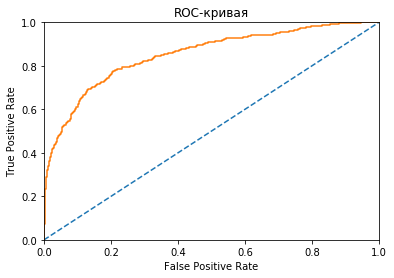

In [34]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# ROC-кривая модели
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

Выбрана балансировка классов с помощью техники upsampling, модель случайного леса показала значение метрики F1 близкое к 0.63 при max_depth=10 - это наивысшее значение среди всех остальных моделей. Значение метрики AUC-ROC достигло значения 0.85. ROC-кривая подтверждает адекватность выбранной модели.

# 4. Тестирование модели

In [35]:
predictions = model.predict(features_test)
f1_score(target_test, predictions)

0.611891891891892

In [36]:
probabilities_one_test = (model.predict_proba(features_test))[:, 1]
roc_auc_score(target_test, probabilities_one_test)

0.8540785013889077

Модель случайного леса с параметрами n_estimators=116 и max_depth=10 успешно прошла тестирование: F1=0.61, AUC-ROC=0.85.